In [14]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm

In [8]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

### Данные:
Будем работать с датасетом [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). 

In [9]:
import os
import struct
import numpy as np


def load_mnist(path, which='train'):

    if which == 'train':
        labels_path = os.path.join(path, 'train-labels-idx1-ubyte')
        images_path = os.path.join(path, 'train-images-idx3-ubyte')
    elif which == 'test':
        labels_path = os.path.join(path, 't10k-labels-idx1-ubyte')
        images_path = os.path.join(path, 't10k-images-idx3-ubyte')
    else:
        raise AttributeError('`which` must be "train" or "test"')

    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, n, rows, cols = struct.unpack('>IIII', imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)

    return images, labels

In [10]:
X_train, y_train = load_mnist(path='../data/', which='train')
X_test, y_test = load_mnist(path='../data/', which='test')

In [12]:
pca = PCA(n_components=3)
used_indices = np.random.choice(
    np.arange(X_train.shape[0]), 10000, replace=False)
X_train_lowdim = pca.fit_transform(X_train[used_indices].reshape([-1, 784]))
lr = LogisticRegression()
lr.fit(X_train_lowdim, y_train[used_indices])
accuracy_score(y_test, lr.predict(pca.transform(X_test.reshape([-1, 784]))))

0.5776

In [15]:
pca_steps = np.arange(2, 80, 3)
n_repeat = 10

results = []
for pca_step in tqdm(pca_steps):

    result_step = []
    for i in range(n_repeat):

        pca = PCA(n_components=pca_step)
        used_indices = np.random.choice(
            np.arange(X_train.shape[0]), 10000, replace=False)
        X_train_reduced = pca.fit_transform(
            X_train[used_indices].reshape([-1, 784]))

        lr = LogisticRegression()
        lr.fit(X_train_reduced, y_train[used_indices])

        acc = accuracy_score(y_test, lr.predict(
            pca.transform(X_test.reshape([-1, 784]))))
        result_step.append(acc)
    results.append(result_step)
    
results = np.array(results)

100%|██████████| 26/26 [1:52:10<00:00, 258.86s/it]


In [41]:
plt.style.use('ggplot')
sns.set(font_scale=2)

def plot_results_std(results, steps, save_name, labels=None, xlabel='X'):
    
    f, ax = plt.subplots(2, 1, figsize=(10, 16))
    results = np.array(results)
    
    if len(results.shape) == 2:
        results = results[np.newaxis, :]
    
    for i, result in enumerate(results):
        
        means = result.mean(axis=1)
        stds = result.std(axis=1)
        if labels is not None:
            label = labels[i]
        else:
            label = 'None'
    
        ax[0].plot(steps, means, '-', ms=10, label=label)
        ax[0].fill_between(steps, means - stds, means + stds, alpha=0.2)
        ax[1].plot(steps, stds**2, label=label)
    
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel('Accuracy score')
    if labels is not None:
        ax[0].legend()
    
    ax[1].set_xlabel(xlabel)
    ax[1].set_ylabel('Variance score')
    if labels is not None:
        ax[1].legend()
    
    plt.ticklabel_format(axis='y',style='sci',scilimits=(1,3))
    plt.savefig(save_name)
    plt.show()

## Plot accuracy score (and errors) from train size

In [31]:
steps = np.hstack([np.arange(10, 200, 20),
                   np.arange(200, 1000, 50),
                   np.arange(1000, 2000, 100)])
n_repeat = 6

results = []
for step in tqdm(steps):
    result_step = []
    for i in range(n_repeat):
        
        used_indices = np.random.choice(np.arange(X_train.shape[0]), step, replace=False)
        
        lr = LogisticRegression()
        lr.fit(X_train[used_indices].reshape([-1, 784]), y_train[used_indices])
        
        acc = accuracy_score(y_test, lr.predict(X_test.reshape([-1, 784])))
        result_step.append(acc)
    results.append(result_step)

100%|██████████| 36/36 [04:14<00:00,  7.06s/it]


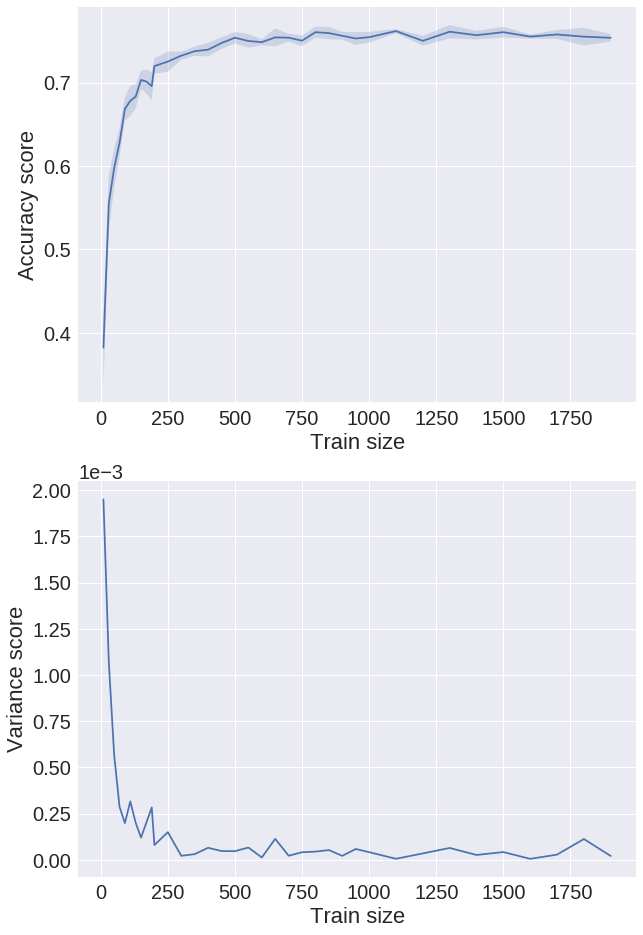

In [39]:
plot_results_std(results, steps, save_name='scores_from_train_size.png', xlabel='Train size')

### Вывод:
 Для получения точности, аналогичной результату работы алгоритмы на всех данных, нам достаточно 500 объектов в обучающей выборке

## Plot accuracy score (and errors) from percentage of used features

In [40]:
steps = np.arange(5, 101, 5) / 100
n_sample = 1000
n_repeat = 6

results = []
for step in tqdm(steps):
    result_step = []
    for i in range(n_repeat):
        
        used_indices = np.random.choice(np.arange(X_train.shape[0]), n_sample, replace=False)
        used_feature = np.random.choice(np.arange(784), int(784 * step), replace=False)
        
        lr = LogisticRegression()
        lr.fit(X_train[used_indices].reshape([-1, 784])[:,used_feature], y_train[used_indices])
        
        acc = accuracy_score(y_test, lr.predict(X_test.reshape([-1, 784])[:,used_feature]))
        result_step.append(acc)
    results.append(result_step)

100%|██████████| 20/20 [02:46<00:00,  8.31s/it]


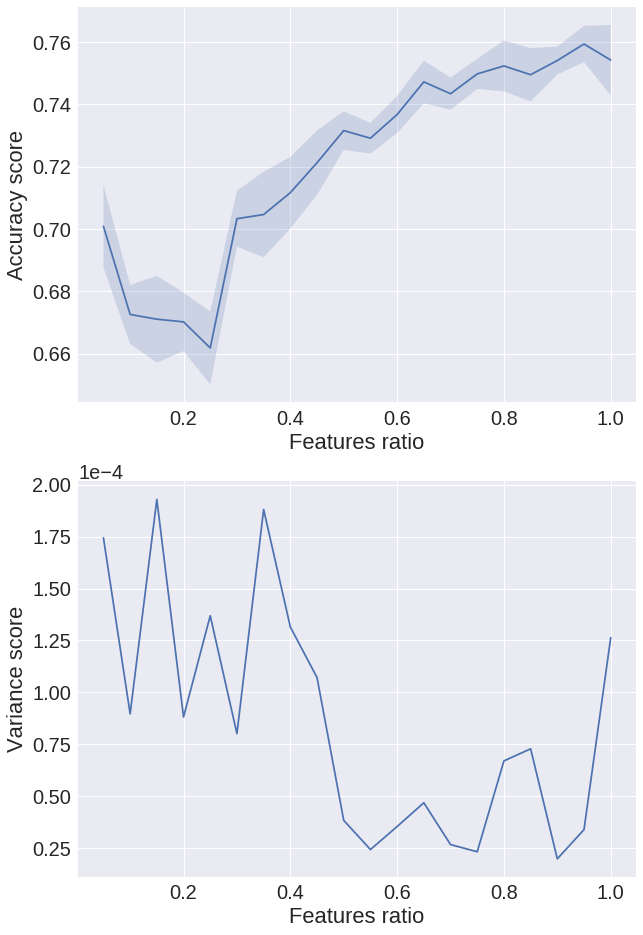

In [42]:
plot_results_std(results, steps, save_name="scores_from_features_ratio.png", xlabel='Features ratio')

### Вывод:
 Точность нелийнено зависит от числа используемых признаков. Лучший результат достигается при исользовании 95% всех признаков